In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ranksums

import glob
import os
import matplotlib.pyplot as plt

from modules.utilities import *
from modules.constants import *
from modules import CliffsDelta
from scipy.stats import shapiro

plt.rcParams.update(mpl_params)
TOPIC_DIR = "./Outputs/BERTopic/Topics"
DATA_DIR = "./Outputs/PerformancePRs"

In [3]:
perf_df = pd.read_csv(os.path.join(DATA_DIR, "POP_PULL_Requests_LLM_filtered_final.csv"))
perf_ids = perf_df["id"].tolist()
perf_df = perf_df[~pd.isna(perf_df["merged_at"])]

In [4]:
pop_df = read_aidev(FileName.POP_PULL_REQUEST)
non_perf_df = pop_df[~pop_df["id"].isin(perf_ids)]
non_perf_df = non_perf_df[~pd.isna(non_perf_df["merged_at"])]
non_perf_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
18,3214555104,16658,Add function signature breaking change detector,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Claude_Code,17039389,harupy,closed,2025-07-09T05:35:26Z,2025-07-11T05:13:35Z,2025-07-11T05:13:35Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16658
19,3214724259,5489,feat: add comprehensive test coverage for form...,## Summary\n\nThis PR enhances the forms plugi...,Claude_Code,82053242,wtfsayo,closed,2025-07-09T06:43:46Z,2025-07-09T06:44:02Z,2025-07-09T06:44:01Z,826170402,https://api.github.com/repos/elizaOS/eliza,https://github.com/elizaOS/eliza/pull/5489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33587,2857168507,1410,Add close button to settings modal,"Added X button to close settings modal, positi...",Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T08:45:02Z,2025-02-17T19:17:14Z,2025-02-17T19:17:14Z,820087727,https://api.github.com/repos/onlook-dev/onlook,https://github.com/onlook-dev/onlook/pull/1410
33588,2857171695,1411,refactor: Port measurement overlay to React,Restores the alt to measure behavior using Rea...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T08:46:25Z,2025-02-18T04:51:00Z,2025-02-18T04:51:00Z,820087727,https://api.github.com/repos/onlook-dev/onlook,https://github.com/onlook-dev/onlook/pull/1411
33590,2857777582,1,"feat: unify button styles, enhance API key dia...","# UI Enhancements: Button Styles, API Key Dial...",Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T12:54:05Z,2025-02-17T13:35:03Z,2025-02-17T13:35:03Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/1
33591,2857942945,2,fix: improve dark mode input focus and toggle ...,# UI Improvements: Dark Mode Input Focus and T...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T13:57:22Z,2025-02-17T14:40:12Z,2025-02-17T14:40:12Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/2


In [5]:
topics = {}
for topic_file in glob.glob(os.path.join(TOPIC_DIR, "*.csv")):
    if "-1" not in topic_file:
        topic_name = os.path.basename(topic_file).replace(".csv", "")
        df = pd.read_csv(topic_file)
        df = df[~pd.isna(df["merged_at"])]
        topics[topic_name] = df

In [6]:
def get_time_to_merge(df, unit='days'):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['merged_at'] = pd.to_datetime(df['merged_at'])
    time_diff = (df['merged_at'] - df['created_at']).dt.total_seconds()
    
    if unit == 'days':
        time_to_merge = time_diff / 86400
    elif unit == 'hours':
        time_to_merge = time_diff / 3600
    elif unit == 'minutes':
        time_to_merge = time_diff / 60
    elif unit == 'seconds':
        time_to_merge = time_diff
    else:
        raise ArgumentError("Invalid unit. Use 'days', 'hours', 'minutes', or 'seconds'.")
    
    return time_to_merge


def get_merge_stats(df, name, unit='days'):
    time_to_merge = get_time_to_merge(df, unit=unit)

    stats = {
        'name': name,
        'min': time_to_merge.min(),
        'max': time_to_merge.max(),
        'mean': time_to_merge.mean(),
        'median': time_to_merge.median(),
        '10th': time_to_merge.quantile(0.1),
        '90th': time_to_merge.quantile(0.9),
    }

    return stats

# General Stat Table

In [7]:
rows = [get_merge_stats(perf_df, "Performance"), get_merge_stats(non_perf_df, "Non-Performance")]
for topic, df in topics.items():
    rows.append(get_merge_stats(df, topic))
stat = pd.DataFrame(rows)

In [8]:
stat

,name,min,max,mean,median,10th,90th
0,Performance,0.000081,67.746898,1.193850,0.002969,0.000127,2.345816
1,Non-Performance,0.000046,74.904097,0.798604,0.001887,0.000139,1.023009
2,topic_12,0.000116,5.359271,0.852622,0.079769,0.021449,2.296688
3,topic_15,0.000220,9.698576,0.747417,0.001759,0.000282,0.004495
4,topic_35,0.000081,1.072002,0.108184,0.000949,0.000093,0.250877
5,topic_43,0.000093,7.182442,0.659271,0.010093,0.000150,0.011435
6,topic_38,0.066030,56.062928,18.442381,8.820284,1.778794,42.803647
7,topic_28,0.001100,6.985625,1.306007,0.055272,0.001140,3.861609
8,topic_3,0.000127,48.547894,3.896238,0.232535,0.000463,6.718380
9,topic_21,0.000127,0.010741,0.002314,0.000243,0.000139,0.010486


# Perf vs Non-Perf

## Boxplot

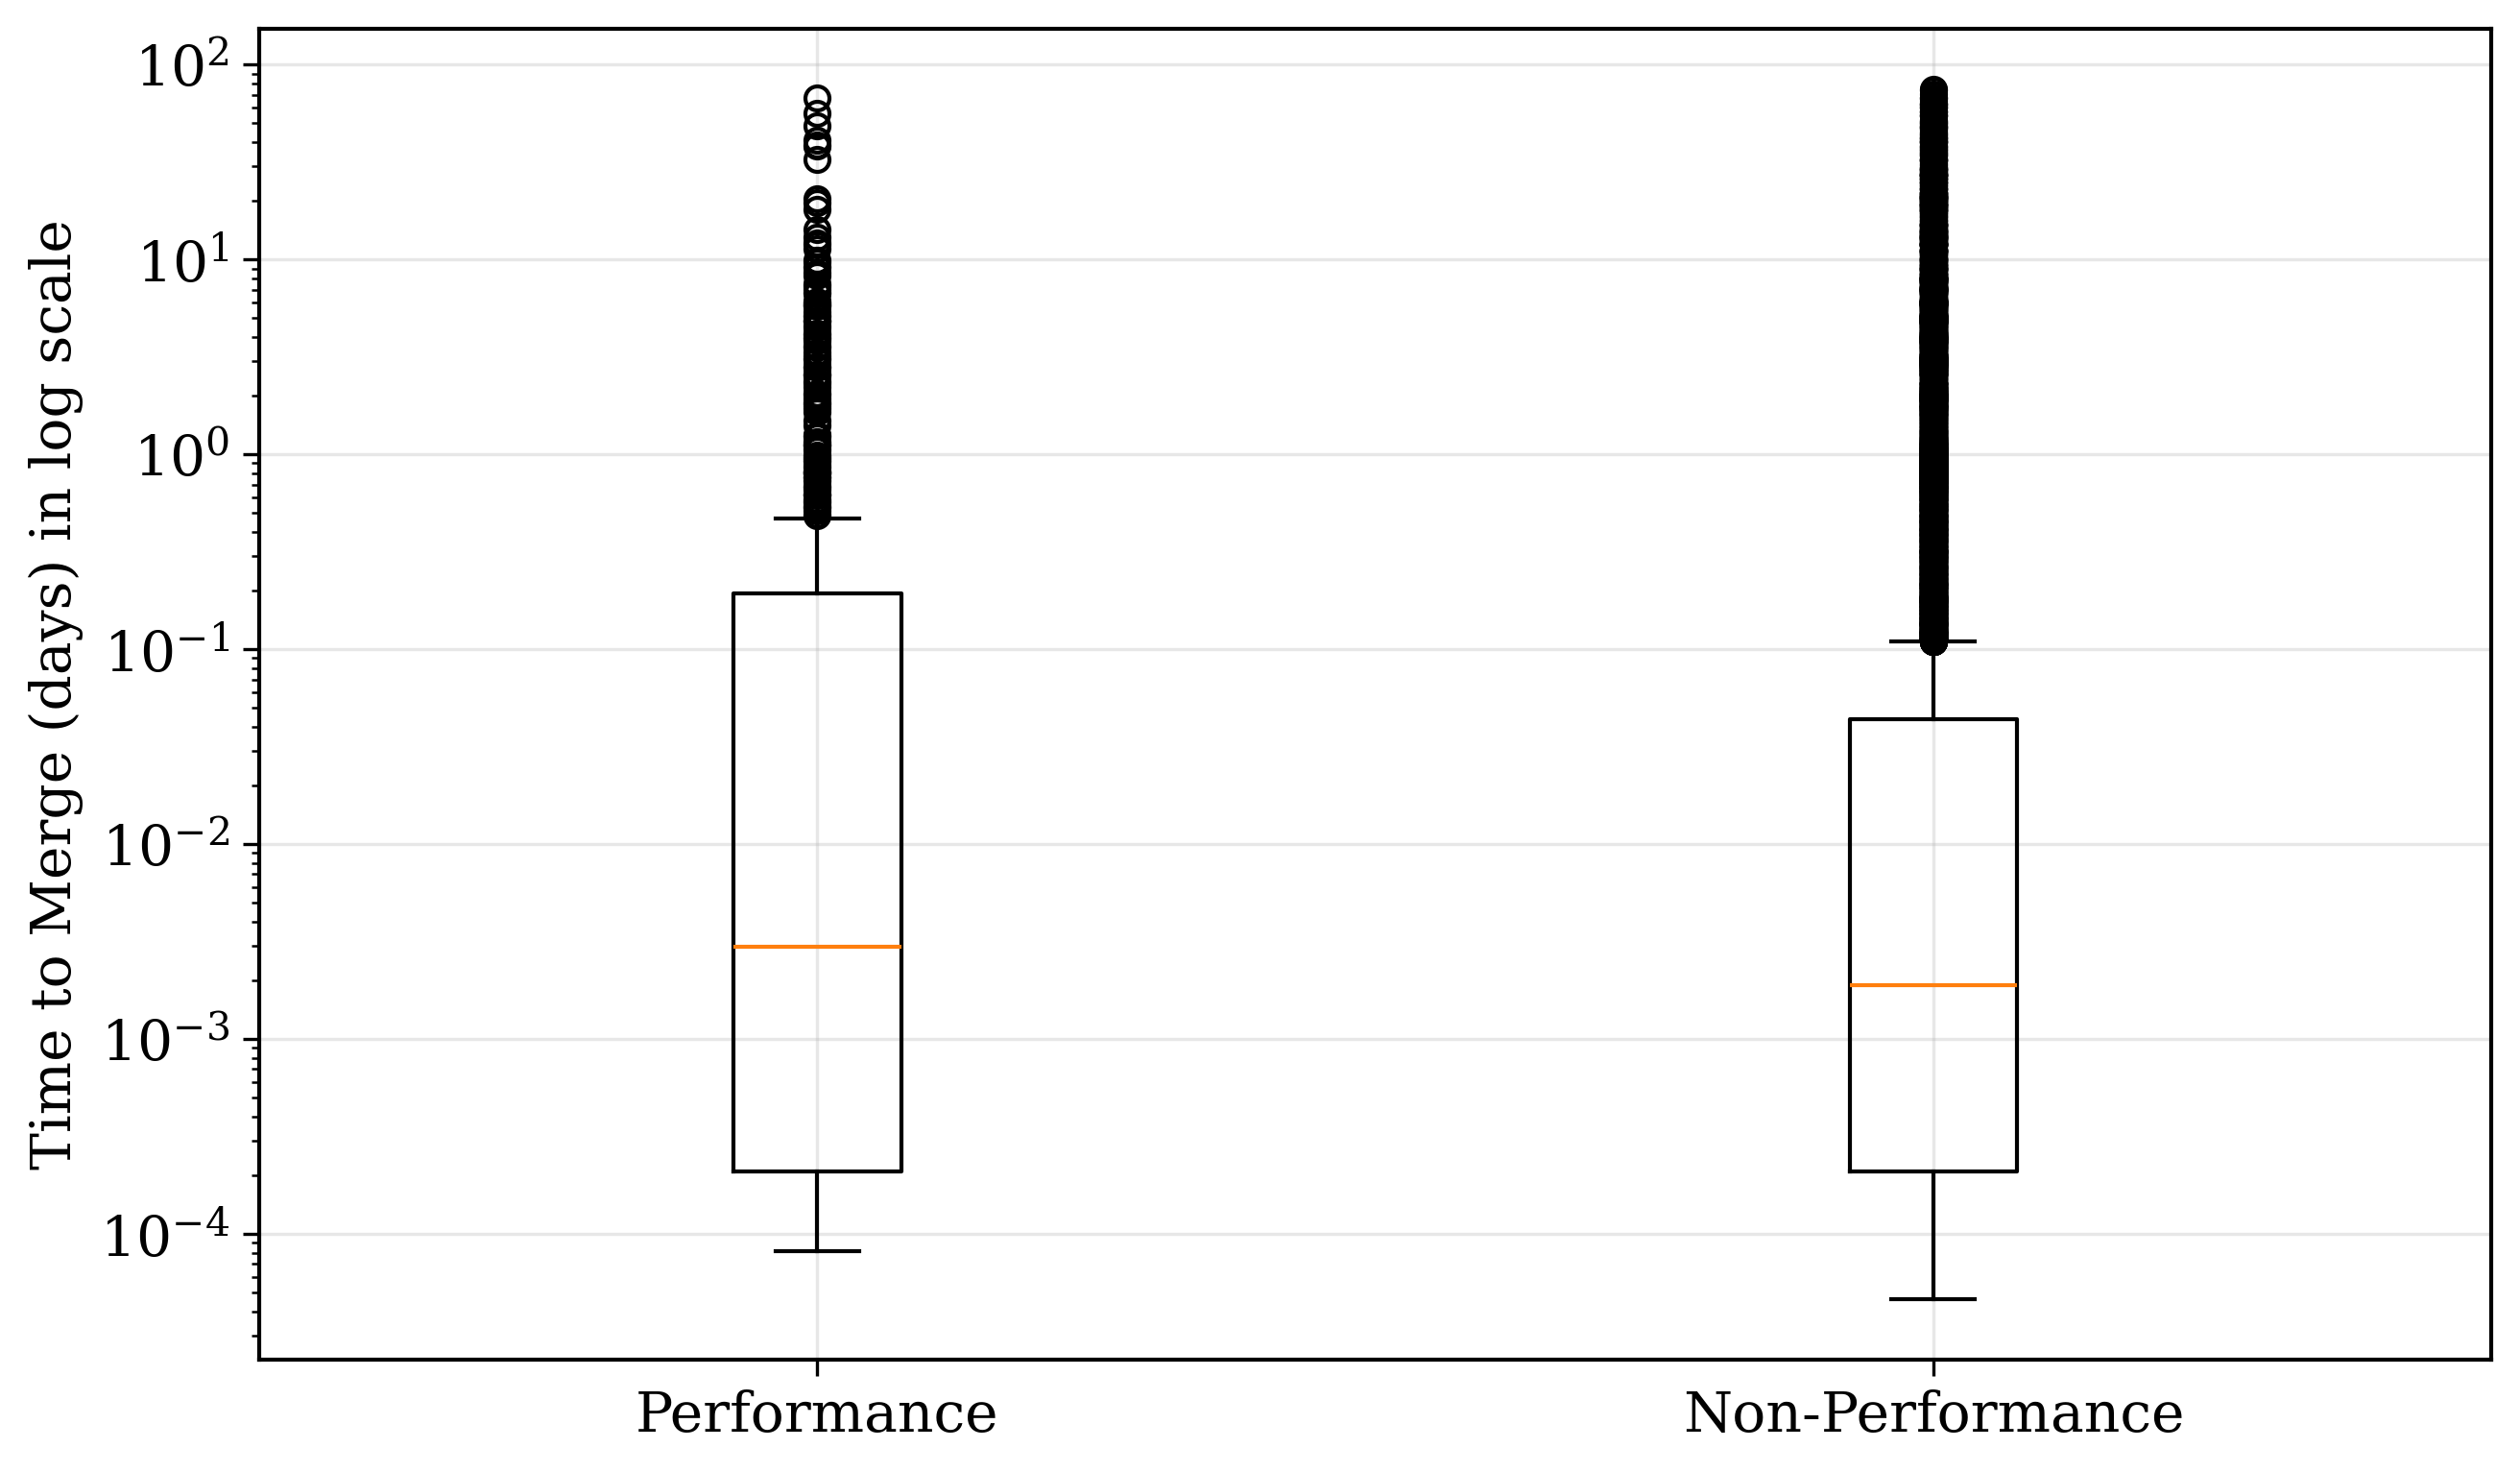

In [9]:
unit = "days"
times_to_merge = [get_time_to_merge(perf_df, unit), get_time_to_merge(non_perf_df, unit)]
labels = ['Performance', 'Non-Performance']


stat = pd.DataFrame({
    'Topic': labels,
    'Median': [np.median(t) for t in times_to_merge],
    'TimeToMerge': times_to_merge
})

stat = stat.sort_values(by='Median', ascending=False)

plt.figure(figsize=(10, 6))
plt.boxplot(stat["TimeToMerge"], tick_labels=stat["Topic"])
plt.yscale('log')
plt.xticks(rotation=0, ha='center')
plt.ylabel(f'Time to Merge ({unit}) in log scale')
plt.grid(True, alpha=0.3)
plt.show()


## Statistical Difference

### Normality Test

In [10]:
# Check if distributions are normal using Shapiro-Wilk test

perf_times = get_time_to_merge(perf_df, unit='days')
non_perf_times = get_time_to_merge(non_perf_df, unit='days')

print("Normality Test (Shapiro-Wilk Test)")
print("=" * 70)

# Test for Performance PRs
perf_stat, perf_p = shapiro(perf_times)
print(f"Performance PRs:")
print(f"  Test Statistic: {perf_stat:.6f}")
print(f"  P-value: {perf_p:.6e}")
print(f"  Distribution: {'Normal' if perf_p > 0.05 else 'Not Normal'} (at α=0.05)")
print()

# Test for Non-Performance PRs
non_perf_stat, non_perf_p = shapiro(non_perf_times)
print(f"Non-Performance PRs:")
print(f"  Test Statistic: {non_perf_stat:.6f}")
print(f"  P-value: {non_perf_p:.6e}")
print(f"  Distribution: {'Normal' if non_perf_p > 0.05 else 'Not Normal'} (at α=0.05)")
print()


Normality Test (Shapiro-Wilk Test)
Performance PRs:
  Test Statistic: 0.226394
  P-value: 6.209665e-46
  Distribution: Not Normal (at α=0.05)

Non-Performance PRs:
  Test Statistic: 0.203866
  P-value: 8.526132e-134
  Distribution: Not Normal (at α=0.05)



/home/cs/grad/opumni/Research/MSR-MiningChallenge26/.conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23346.
  res = hypotest_fun_out(*samples, **kwds)


In [11]:
# Observed statistic
statistic, p_value = ranksums(perf_times, non_perf_times)

rng = np.random.default_rng(42)
n_bootstrap = 10_000

bootstrap_stats = []
bootstrap_ses = []

for _ in range(n_bootstrap):
    perf_sample = rng.choice(perf_times, size=len(perf_times), replace=True)
    non_perf_sample = rng.choice(non_perf_times, size=len(non_perf_times), replace=True)

    # Bootstrap statistic
    stat_star = ranksums(perf_sample, non_perf_sample).statistic
    bootstrap_stats.append(stat_star)

# Convert to array
bootstrap_stats = np.array(bootstrap_stats)

# Bootstrap estimate of standard error
bootstrap_se = bootstrap_stats.std(ddof=1)

# Studentized bootstrap statistics
bootstrap_t = (bootstrap_stats - statistic) / bootstrap_se

# Bootstrap-t p-value (two-sided)
bootstrap_t_p_value = np.mean(np.abs(bootstrap_t) >= np.abs(statistic / bootstrap_se))

print("Wilcoxon Rank-Sum Test with Bootstrap-t")
print(f"\nObserved Z Statistic: {statistic:.4f}")
print(f"Asymptotic P-value: {p_value:.6f}")
print(f"Bootstrap-t P-value: {bootstrap_t_p_value:.6f}")
print()

if bootstrap_t_p_value < 0.001:
    print("Result: Statistically significant difference (bootstrap-t p < 0.001)")
elif bootstrap_t_p_value < 0.01:
    print("Result: Statistically significant difference (bootstrap-t p < 0.01)")
elif bootstrap_t_p_value < 0.05:
    print("Result: Statistically significant difference (bootstrap-t p < 0.05)")
else:
    print("Result: No statistically significant difference (bootstrap-t p >= 0.05)")


Wilcoxon Rank-Sum Test with Bootstrap-t

Observed Z Statistic: 2.6066
Asymptotic P-value: 0.009144
Bootstrap-t P-value: 0.013300

Result: Statistically significant difference (bootstrap-t p < 0.05)


In [12]:
delta, size = CliffsDelta.cliffsDelta(perf_times, non_perf_times)

print("Cliff's Delta Effect Size Analysis")
print("=" * 50)
print(f"\nCliff's Delta: {delta:.4f}")
print(f"Effect Size: {size}")


Cliff's Delta Effect Size Analysis

Cliff's Delta: 0.0591
Effect Size: negligible


# All topic

## Boxplot

In [13]:
topics.keys()

dict_keys(['topic_12', 'topic_15', 'topic_35', 'topic_43', 'topic_38', 'topic_28', 'topic_3', 'topic_21', 'topic_41', 'topic_33', 'topic_50', 'topic_1', 'topic_26', 'topic_25', 'topic_37', 'topic_27', 'topic_48', 'topic_16', 'topic_18', 'topic_11', 'topic_30', 'topic_4', 'topic_7', 'topic_2', 'topic_6', 'topic_14', 'topic_0', 'topic_19', 'topic_31', 'topic_29', 'topic_47', 'topic_5', 'topic_45', 'topic_40', 'topic_20', 'topic_42', 'topic_51', 'topic_8', 'topic_17', 'topic_24', 'topic_22', 'topic_39', 'topic_34', 'topic_44', 'topic_32', 'topic_13', 'topic_10', 'topic_9', 'topic_46', 'topic_49', 'topic_23', 'topic_36'])

In [14]:
category_dfs = {}
for category, topic_list in category_map.items():
    dfs_to_concat = []
    for topic in topic_list:
        if topic in topics:
            df = topics[topic].copy()
            df['topic'] = topic
            df['topic_name'] = topic_map.get(topic, topic)
            df['category'] = category
            dfs_to_concat.append(df)
    
    if dfs_to_concat:
        category_dfs[category] = pd.concat(dfs_to_concat, ignore_index=True)

# Display the categories and their sizes
for category, df in category_dfs.items():
    print(f"{category}: {len(df)} PRs")

Development: 119 PRs
Low-level: 174 PRs
UI: 65 PRs
Caching: 55 PRs
Algorithmic: 56 PRs
Query: 32 PRs
Networking: 54 PRs
Monitoring and Evaluation: 28 PRs
Hardware: 27 PRs
AI: 15 PRs


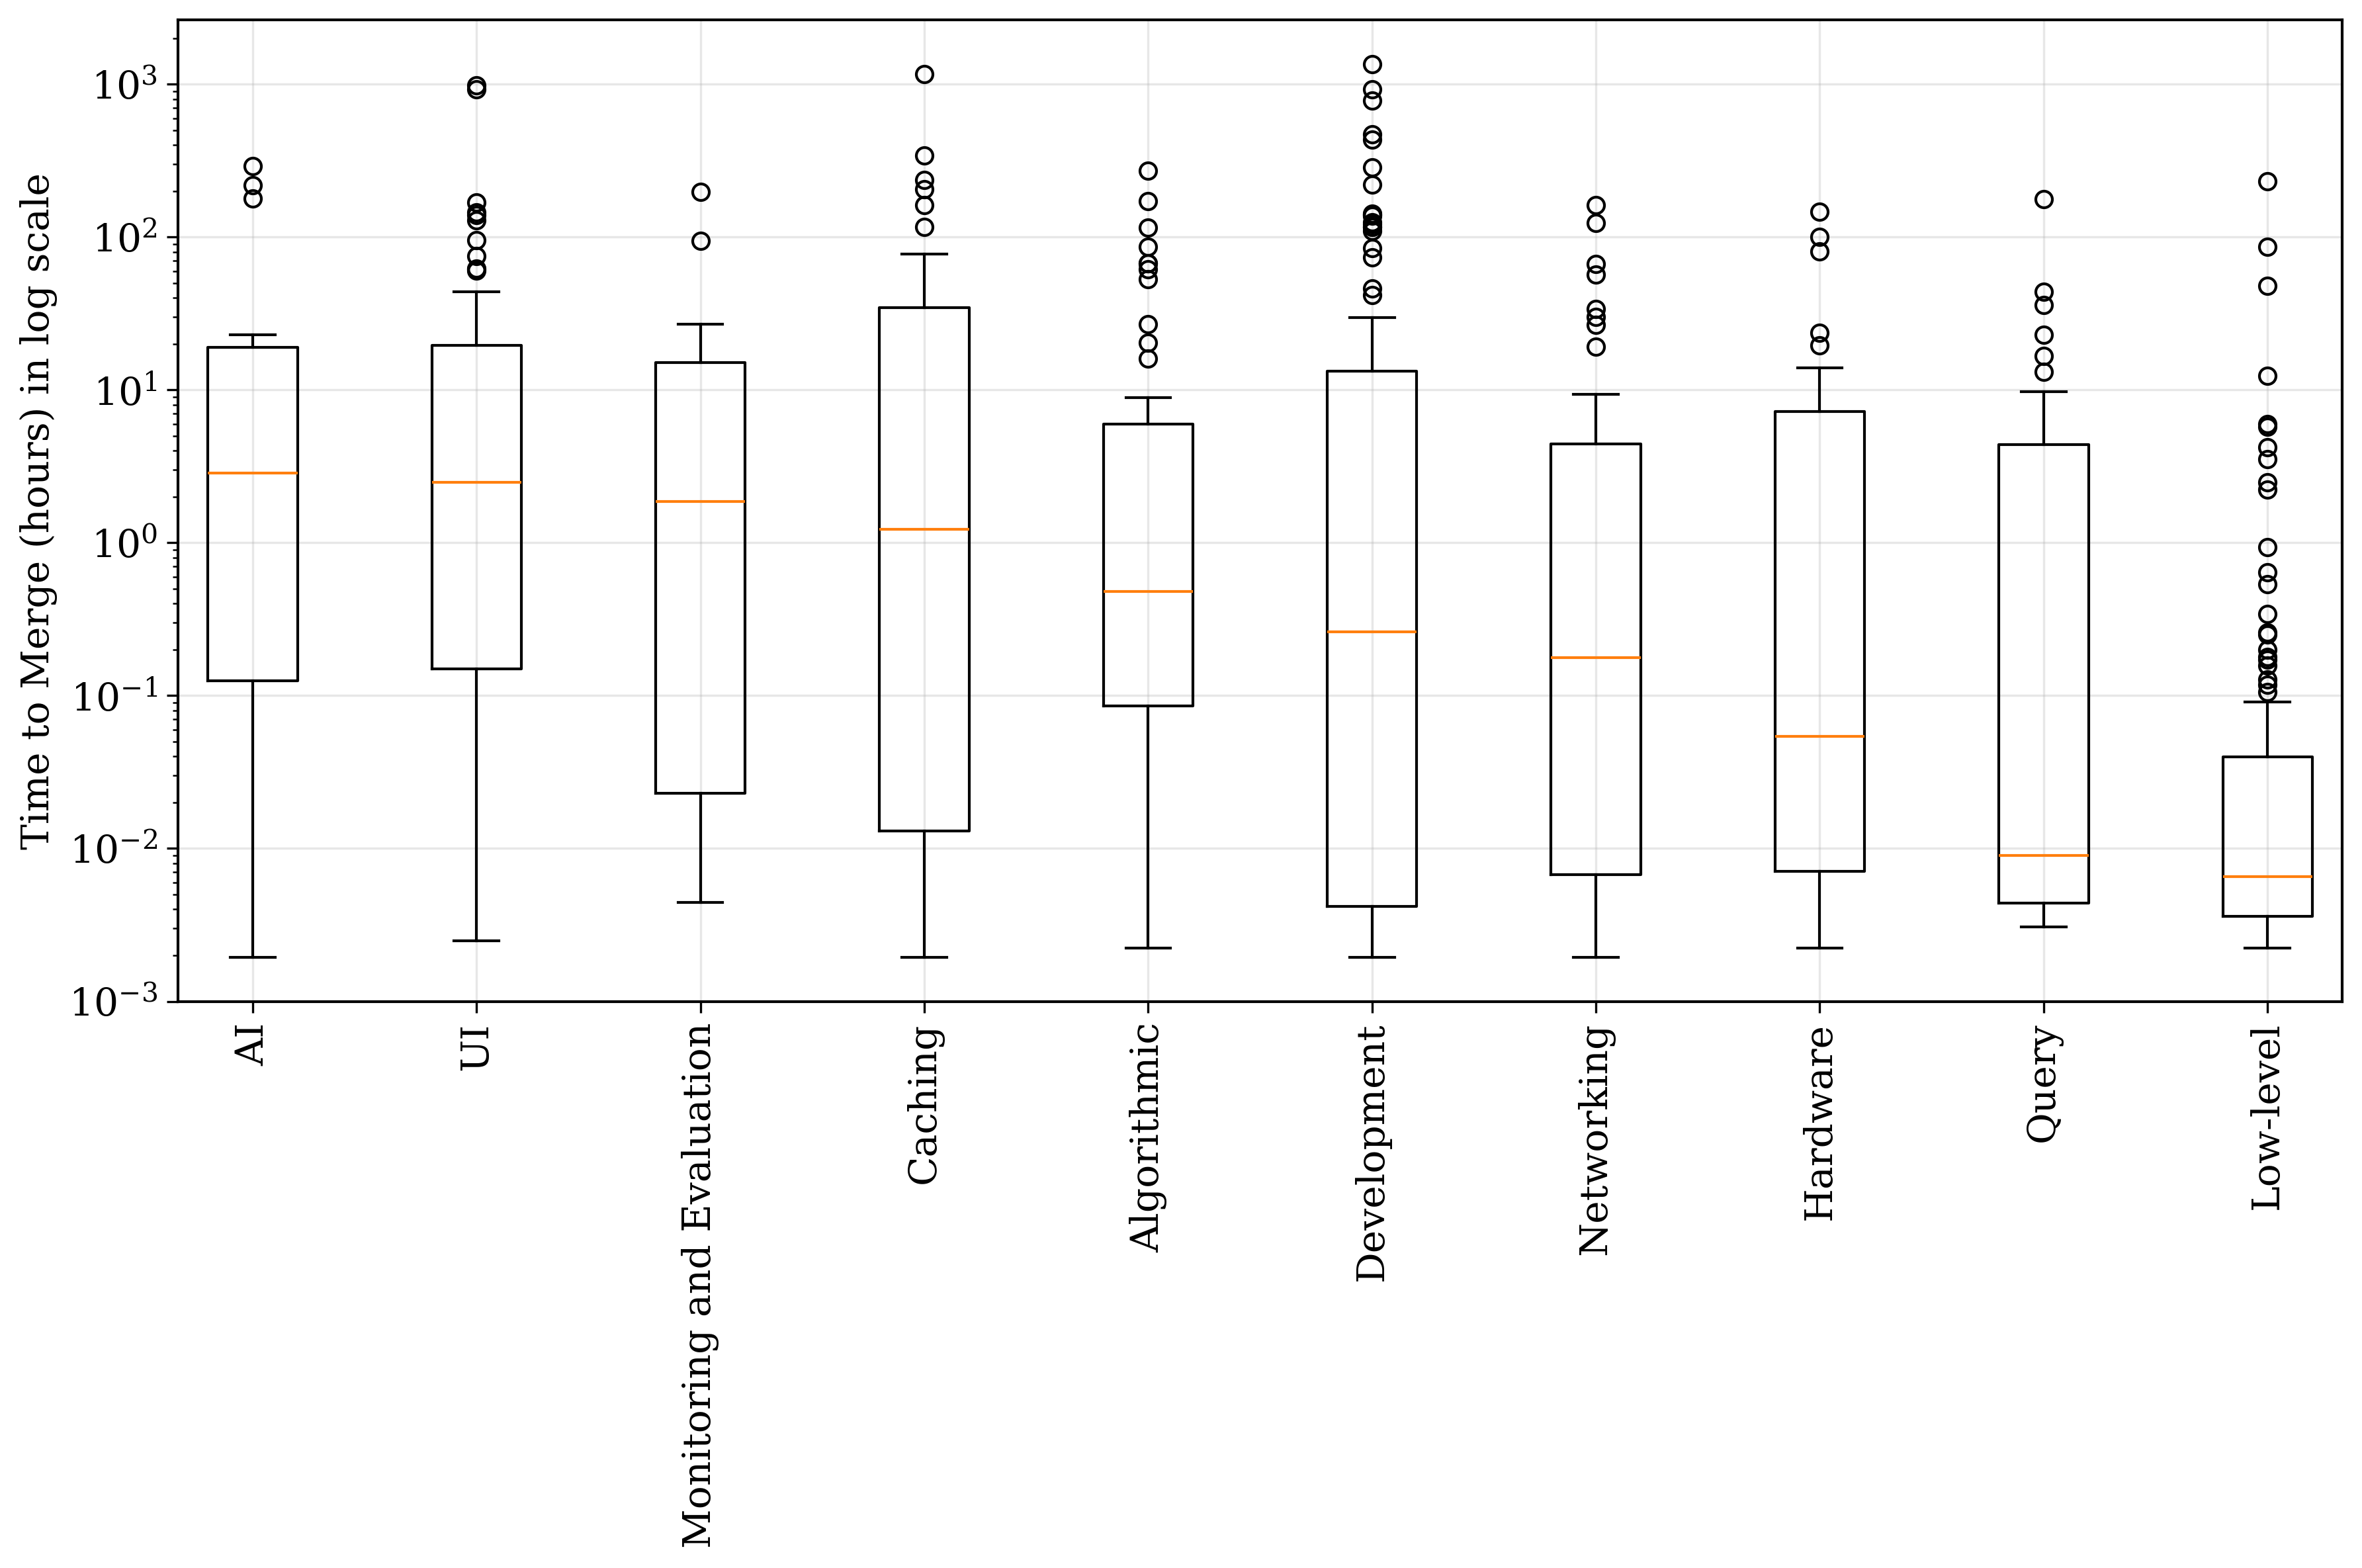

In [16]:
times_to_merge = []
median = []
labels = []

unit = "hours"

for category, df in category_dfs.items():
    merge_times = get_time_to_merge(df, unit=unit)
    times_to_merge.append(merge_times)
    median.append(np.median(merge_times))
    labels.append(category)
    
stat = pd.DataFrame({
    'Topic': labels,
    'Median': median,
    'TimeToMerge': times_to_merge
})

stat = stat.sort_values(by='Median', ascending=False)

plt.figure(figsize=(12, 8))
positions = np.arange(len(stat)) * 1.5
plt.boxplot(stat["TimeToMerge"], positions=positions, widths=0.6)
plt.xticks(positions, stat["Topic"], rotation=90, ha='center')
plt.yscale('log')
plt.ylabel(f'Time to Merge ({unit}) in log scale')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
